In [296]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score, RocCurveDisplay,make_scorer,
                             ConfusionMatrixDisplay)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from mlflow import log_metric, log_param, log_artifact, start_run, end_run
from mlflow.sklearn import log_model, autolog
from mlflow.xgboost import autolog as xgb_autolog
from mlflow.models import infer_signature
import joblib
from tqdm import tqdm
import os
import re
import seaborn as sns

warnings.filterwarnings("ignore")

def set_seed(seed):
    """Set the random seed for reproducibility."""
    np.random.seed(seed)


set_seed(42)
pd.set_option("display.max_columns", None)

In [297]:
df = pd.read_csv("data/diabetic_cleaned.csv")

In [298]:
df.drop(columns=['readmitted_binary'], inplace=True, errors='ignore')
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'admission_type', 'discharge_disposition', 'admission_source'],
      dtype='object')

In [299]:
def engineer_top_features(df):
    df = df.copy()

    # 1. Indicateur d'expiration (décès)
    df['expiration_ind'] = df['discharge_disposition_id'].isin([11, 13, 14, 19, 20, 21]).astype(int)

    # 2. Médicaments importants (compte et intensité)
    important_drugs = ['metformin', 'repaglinide', 'glimepiride', 'pioglitazone', 
                       'rosiglitazone', 'glyburide', 'glipizide', 'insulin']
    
    df['active_med_count'] = df[important_drugs].apply(lambda x: (x != 'No').sum(), axis=1)
    df['med_intensity'] = df[important_drugs].apply(lambda x: sum(1 for m in x if m in ['Up', 'Down']), axis=1)

    # 3. Features composites
    df['urgent_care_ratio'] = (df['number_emergency'] + 1) / (df['number_outpatient'] + 1)
    df['stay_procedure_ratio'] = df['time_in_hospital'] / (df['num_procedures'] + 1)
    df['med_complexity_score'] = (df['num_medications'] * 0.5 + df['active_med_count'] * 0.3 + df['med_intensity'] * 0.2)

    # 4. Diagnostiques (classification des codes)
    def map_diag_code(diag):
        try:
            code = float(diag)
        except:
            return 'other'
        if 250 <= code < 251: return 'diabetes'
        elif 390 <= code <= 459: return 'cardiovascular'
        elif 580 <= code <= 629: return 'renal'
        elif code in [3051, 303, 305]: return 'substance_abuse'
        else: return 'other'
    
    for col in ['diag_1', 'diag_2', 'diag_3']:
        df[f'{col}_group'] = df[col].apply(map_diag_code)

    # 5. Abnormal stay (séjour anormal)
    df['abnormal_stay'] = pd.cut(df['time_in_hospital'], 
                                 bins=[0, 2, 5, 10, float('inf')], 
                                 labels=['very_short', 'short', 'normal', 'long'])

    # 6. Instabilité thérapeutique : changement de traitement
    df['therapy_instability'] = (df[important_drugs].isin(['Up', 'Down']).sum(axis=1) > 1).astype(int)

    # 7. Comorbidité et variabilité du diagnostic
    df['comorbidity_count'] = df[['diag_1_group', 'diag_2_group', 'diag_3_group']].nunique(axis=1)
    df['diag_variability'] = (df['diag_1'] != df['diag_2']).astype(int) + (df['diag_2'] != df['diag_3']).astype(int)

    df['readmitted_lt30_ind'] = ( df['readmitted']=='<30' ).astype(int)
    df['readmitted_gt30_ind'] = ( df['readmitted']=='>30' ).astype(int)
    df['readmitted_no_ind'] = ( df['readmitted']=='NO' ).astype(int)
    df['readmitted_ind'] = df['readmitted_lt30_ind'] + df['readmitted_gt30_ind']
    readmission_history_features = [
        'mb_readmitted_gt30_ct', 'mb_readmitted_no_ct',
        'prior_30day_readmits', 'mb_readmitted_lt30_ct'
    ]
    
    # Si l’une d’elles est absente dans df, on la met à 0 (utile pour nouveaux patients)
    for col in readmission_history_features:
        if col not in df.columns:
            df[col] = 0

    # 9. Sélection des features finales
    final_features = [
        # Variables clés pour le modèle
        'expiration_ind', 'prior_30day_readmits', 'total_prior_admissions',
        'number_inpatient', 'number_emergency', 'number_outpatient',
        'number_diagnoses', 'time_in_hospital', 'num_procedures', 'num_medications',
        'num_lab_procedures', 'urgent_care_ratio', 'stay_procedure_ratio',
        'med_complexity_score', 'active_med_count', 'med_intensity',
        'therapy_instability', 'comorbidity_count', 'diag_variability',
        'avg_stay_duration', 'max_stay_duration', 'lifetime_inpatient_visits',
        'lifetime_emergency_visits', 'encounter_ct', 'mb_time_in_hospital',
        'mb_readmitted_lt30_ct', 'mb_readmitted_gt30_ct', 'mb_readmitted_no_ct',
        'mb_num_lab_procedures_ct', 'mb_num_procedures_ct', 'mb_num_medications_ct',
        'mb_number_outpatient_ct', 'mb_number_emergency_ct', 'mb_number_inpatient_ct',
        'mb_number_diagnoses_ct', 'major_chronic_diag',

        # Variables catégorielles
        'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
        'age', 'race', 'gender', 'max_glu_serum', 'A1Cresult',
        'metformin', 'repaglinide', 'glimepiride', 'pioglitazone',
        'rosiglitazone', 'glyburide', 'glipizide', 'insulin',
        'diag_1_group', 'diag_2_group', 'diag_3_group', 'abnormal_stay',
        'change', 'diabetesMed'
    ]

    # Ajout des features patient-level (mb_)
    df['encounter_ct'] = df['patient_nbr'].map(df.groupby('patient_nbr')['encounter_id'].nunique())
    df['mb_time_in_hospital'] = df.groupby('patient_nbr')['time_in_hospital'].transform('sum')
    df['mb_readmitted_lt30_ct'] = df.groupby('patient_nbr')['readmitted_lt30_ind'].transform('sum')
    df['mb_readmitted_gt30_ct'] = df.groupby('patient_nbr')['readmitted_gt30_ind'].transform('sum')
    df['mb_readmitted_no_ct'] = df.groupby('patient_nbr')['readmitted_no_ind'].transform('sum')
    df['mb_num_lab_procedures_ct'] = df.groupby('patient_nbr')['num_lab_procedures'].transform('sum')
    df['mb_num_procedures_ct'] = df.groupby('patient_nbr')['num_procedures'].transform('sum')
    df['mb_num_medications_ct'] = df.groupby('patient_nbr')['num_medications'].transform('sum')
    df['mb_number_outpatient_ct'] = df.groupby('patient_nbr')['number_outpatient'].transform('sum')
    df['mb_number_emergency_ct'] = df.groupby('patient_nbr')['number_emergency'].transform('sum')
    df['mb_number_inpatient_ct'] = df.groupby('patient_nbr')['number_inpatient'].transform('sum')
    df['mb_number_diagnoses_ct'] = df.groupby('patient_nbr')['number_diagnoses'].transform('sum')

    # Droper les features inutiles
    to_drop = ['readmitted_lt30_ind', 'readmitted_gt30_ind', 'readmitted_no_ind']
    df = df.drop(columns=to_drop, errors='ignore')

    # Retourner uniquement les features sélectionnées
    df = df[[col for col in final_features if col in df.columns]]
    
    return df


In [300]:
y = df["readmitted"]

In [301]:
df_features_eng = engineer_top_features(df)
df_features_eng.head()

,expiration_ind,prior_30day_readmits,number_inpatient,number_emergency,number_outpatient,number_diagnoses,time_in_hospital,num_procedures,num_medications,num_lab_procedures,urgent_care_ratio,stay_procedure_ratio,med_complexity_score,active_med_count,med_intensity,therapy_instability,comorbidity_count,diag_variability,encounter_ct,mb_time_in_hospital,mb_readmitted_lt30_ct,mb_readmitted_gt30_ct,mb_readmitted_no_ct,mb_num_lab_procedures_ct,mb_num_procedures_ct,mb_num_medications_ct,mb_number_outpatient_ct,mb_number_emergency_ct,mb_number_inpatient_ct,mb_number_diagnoses_ct,admission_type_id,discharge_disposition_id,admission_source_id,age,race,gender,max_glu_serum,A1Cresult,metformin,repaglinide,glimepiride,pioglitazone,rosiglitazone,glyburide,glipizide,insulin,diag_1_group,diag_2_group,diag_3_group,abnormal_stay,change,diabetesMed
0,0,0,0,0,0,9,3,0,18,59,1.000000,3.000000,9.5,1,1,0,2,2,1,3,0,1,0,59,0,18,0,0,0,9,1,1,7,[10-20),Caucasian,Female,Not Measured,Not Measured,No,No,No,No,No,No,No,Up,other,diabetes,other,short,Ch,Yes
1,0,0,1,0,2,6,2,5,13,11,0.333333,0.333333,6.8,1,0,0,2,2,1,2,0,0,1,11,5,13,2,0,1,6,1,1,7,[20-30),AfricanAmerican,Female,Not Measured,Not Measured,No,No,No,No,No,No,Steady,No,other,diabetes,other,very_short,No,Yes
2,0,0,0,0,0,7,2,1,16,44,1.000000,1.000000,8.5,1,1,0,3,2,1,2,0,0,1,44,1,16,0,0,0,7,1,1,7,[30-40),Caucasian,Male,Not Measured,Not Measured,No,No,No,No,No,No,No,Up,other,diabetes,cardiovascular,very_short,Ch,Yes
3,0,0,0,0,0,5,1,0,8,51,1.000000,1.000000,4.6,2,0,0,2,2,1,1,0,0,1,51,0,8,0,0,0,5,1,1,7,[40-50),Caucasian,Male,Not Measured,Not Measured,No,No,No,No,No,No,Steady,Steady,other,other,diabetes,very_short,Ch,Yes
4,0,0,0,0,0,9,3,6,16,31,1.000000,0.428571,8.3,1,0,0,2,2,1,3,0,1,0,31,6,16,0,0,0,9,2,1,2,[50-60),Caucasian,Male,Not Measured,Not Measured,No,No,No,No,No,No,No,Steady,cardiovascular,cardiovascular,diabetes,short,No,Yes


In [302]:
df_features_eng.isna().sum().sum()

np.int64(0)

In [303]:
df_features_eng.columns

Index(['expiration_ind', 'prior_30day_readmits', 'number_inpatient',
       'number_emergency', 'number_outpatient', 'number_diagnoses',
       'time_in_hospital', 'num_procedures', 'num_medications',
       'num_lab_procedures', 'urgent_care_ratio', 'stay_procedure_ratio',
       'med_complexity_score', 'active_med_count', 'med_intensity',
       'therapy_instability', 'comorbidity_count', 'diag_variability',
       'encounter_ct', 'mb_time_in_hospital', 'mb_readmitted_lt30_ct',
       'mb_readmitted_gt30_ct', 'mb_readmitted_no_ct',
       'mb_num_lab_procedures_ct', 'mb_num_procedures_ct',
       'mb_num_medications_ct', 'mb_number_outpatient_ct',
       'mb_number_emergency_ct', 'mb_number_inpatient_ct',
       'mb_number_diagnoses_ct', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'age', 'race',
       'gender', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide',
       'glimepiride', 'pioglitazone', 'rosiglitazone', 'glyburide',
       'glipi

In [304]:
df_features_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100241 entries, 0 to 100240
Data columns (total 52 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   expiration_ind            100241 non-null  int64   
 1   prior_30day_readmits      100241 non-null  int64   
 2   number_inpatient          100241 non-null  int64   
 3   number_emergency          100241 non-null  int64   
 4   number_outpatient         100241 non-null  int64   
 5   number_diagnoses          100241 non-null  int64   
 6   time_in_hospital          100241 non-null  int64   
 7   num_procedures            100241 non-null  int64   
 8   num_medications           100241 non-null  int64   
 9   num_lab_procedures        100241 non-null  int64   
 10  urgent_care_ratio         100241 non-null  float64 
 11  stay_procedure_ratio      100241 non-null  float64 
 12  med_complexity_score      100241 non-null  float64 
 13  active_med_count          100

In [305]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


In [306]:
X_train, X_test, y_train, y_test = train_test_split(df_features_eng, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [307]:
cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

In [308]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop='first', sparse_output=False), cat_features),
    ]
)

In [309]:
def clean_feature_names(df):
    df.columns = [re.sub(r'[\[\]]', '', str(col)) for col in df.columns]
    df.columns = [re.sub(r'>', 'sup_', str(col)) for col in df.columns]
    df.columns = [re.sub(r'<', 'inf_', str(col)) for col in df.columns]
    return df


In [310]:
def multiclass_auc_scorer(estimator, X, y):
    y_proba = estimator.predict_proba(X)
    return roc_auc_score(
        y,
        y_proba,
        multi_class='ovo', 
        average='weighted' 
    )

In [311]:
xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    n_estimators=4000,
    verbose=0,
)

In [312]:
pipeline_xgb = Pipeline([
    ("preprocess", preprocess),
    ("classifier", xgb)
])
pipeline_pca_xgb = Pipeline([
    ("preprocess", preprocess),
    ("pca", PCA(n_components=0.95)),
    ("classifier", xgb)
])

In [313]:
xgb.get_params()

{'objective': 'multi:softmax',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 4000,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'num_class': 3,
 'use_label_encoder'

In [316]:
import mlflow
import mlflow.sklearn

features_used = list(X_train.columns)


mlflow.set_experiment("Diabetes_Readmission_Prediction_2")

def plot_feature_importances(model, feature_names, model_name, top_n=10):
    """Plot the feature importances of a model."""
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    sns.set_style("whitegrid")
    sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], orient='h')
    plt.figure(figsize=(10, 6))
    plt.title(f"{model_name}Feature Importances")
    plt.bar(range(top_n), importances[indices], align="center")
    plt.xticks(range(top_n), np.array(feature_names)[indices], rotation=90)
    plt.xlim([-1, top_n])
    plt.show()

def log_model_details(model, model_name, features, params, metrics):
    """Helper function to log model details to MLflow"""
    mlflow.log_params(params)
    mlflow.log_metrics(metrics)
    mlflow.set_tag("model_type", model_name)
    mlflow.set_tag("features", str(features))

Classification Report:
 {'0': {'precision': 0.726078799249531, 'recall': 0.688, 'f1-score': 0.7065267001369238, 'support': 2250.0}, '1': {'precision': 0.8552267699115044, 'recall': 0.8791755508173419, 'f1-score': 0.8670358169201654, 'support': 7035.0}, '2': {'precision': 0.9693963500233973, 'recall': 0.9622816796729841, 'f1-score': 0.9658259126299594, 'support': 10764.0}, 'accuracy': 0.9023392687914609, 'macro avg': {'precision': 0.8502339730614775, 'recall': 0.8431524101634419, 'f1-score': 0.8464628098956828, 'support': 20049.0}, 'weighted avg': {'precision': 0.9020290257015674, 'recall': 0.9023392687914609, 'f1-score': 0.9020615577280823, 'support': 20049.0}}
Confusion Matrix:
 [[ 1548   677    25]
 [  548  6185   302]
 [   36   370 10358]]


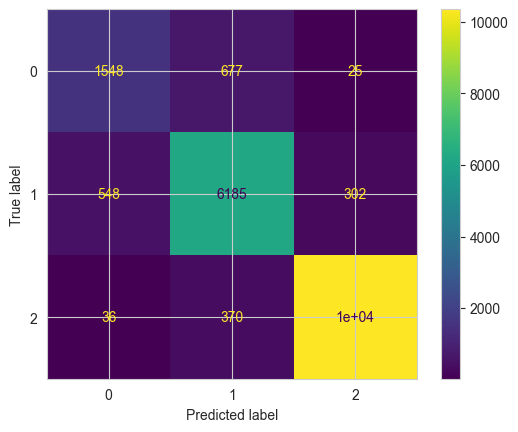

2025/04/14 02:36:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [317]:
with mlflow.start_run(run_name="XGBoost_Model_feature_importance", nested=True) as run:
    pipeline_xgb.fit(X_train, y_train)
    y_train_pred = pipeline_xgb.predict(X_train)
    y_test_pred = pipeline_xgb.predict(X_test)
    y_train_proba = pipeline_xgb.predict_proba(X_train)
    scores_report = classification_report(y_test, y_test_pred, output_dict=True)
    print("Classification Report:\n", scores_report)
    print("Confusion Matrix:\n", confusion_matrix(y_test,y_test_pred))
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred)).plot()
    plt.show()
    # Evaluate
    xgb_metrics = {
        'train_auc': multiclass_auc_scorer(pipeline_xgb, X_train, y_train),
        'test_auc': multiclass_auc_scorer(pipeline_xgb, X_test, y_test),
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'train_precision': scores_report["weighted avg"]["precision"],
        'test_precision': scores_report["weighted avg"]["precision"],
        'train_recall': scores_report["weighted avg"]["recall"],
        'test_recall': scores_report["weighted avg"]["recall"],
        'train_f1': scores_report["weighted avg"]["f1-score"],
        'test_f1': scores_report["weighted avg"]["f1-score"]
    }
    
    # Log to MLflow
    mlflow.xgboost.log_model(xgb, "xgboost_model")
    log_model_details(xgb, "XGBoost", features_used, xgb.get_params(), xgb_metrics)


In [318]:
print(classification_report(y_test, pipeline_xgb.predict(X_test)))
print("Train AUC:", multiclass_auc_scorer(pipeline_xgb, X_train, y_train))
print("Test AUC:", multiclass_auc_scorer(pipeline_xgb, X_test, y_test))

              precision    recall  f1-score   support

           0       0.73      0.69      0.71      2250
           1       0.86      0.88      0.87      7035
           2       0.97      0.96      0.97     10764

    accuracy                           0.90     20049
   macro avg       0.85      0.84      0.85     20049
weighted avg       0.90      0.90      0.90     20049

Train AUC: 1.0
Test AUC: 0.978649414269156


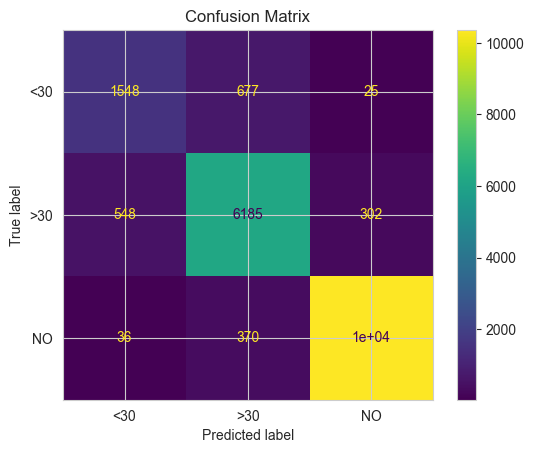

In [319]:
cm = confusion_matrix(y_test, pipeline_xgb.predict(X_test))
ConfusionMatrixDisplay(cm).plot()
plt.xticks([0, 1, 2], label_encoder.inverse_transform([0, 1, 2]))
plt.yticks([0, 1, 2],label_encoder.inverse_transform([0, 1, 2]))
plt.title("Confusion Matrix")
plt.show()

In [320]:
rf_model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    n_estimators=1000,
    verbose=0,
)

rf_model

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

In [329]:
pipeline_rf = Pipeline([
    ("preprocess", preprocess),
    ("classifier", rf_model)
])
pipeline_rf

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['expiration_ind',
                                                   'prior_30day_readmits',
                                                   'number_inpatient',
                                                   'number_emergency',
                                                   'number_outpatient',
                                                   'number_diagnoses',
                                                   'time_in_hospital',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'num_lab_procedures',
                                                   'urgent_care_ratio',
                                                   'stay_procedure_ratio',
                                                   'med_complexity_score',
                                                   'active...
                                                                sparse_output=False),
                                                  ['age', 'race', 'gender',
                                                   'max_glu_serum', 'A1Cresult',
                                                   'metformin', 'repaglinide',
                                                   'glimepiride',
                                                   'pioglitazone',
                                                   'rosiglitazone', 'glyburide',
                                                   'glipizide', 'insulin',
                                                   'diag_1_group',
                                                   'diag_2_group',
                                                   'diag_3_group',
                                                   'abnormal_stay', 'change',
                                                   'diabetesMed'])])),
                ('classifier',
                 RandomForestClassifier(n_estimators=1000, n_jobs=-1,
                                        random_state=42))])

Classification Report:
 {'0': {'precision': 0.779306549257017, 'recall': 0.6293333333333333, 'f1-score': 0.6963363658716498, 'support': 2250.0}, '1': {'precision': 0.825031605562579, 'recall': 0.9276474769012082, 'f1-score': 0.8733355637336901, 'support': 7035.0}, '2': {'precision': 0.9778143770587095, 'recall': 0.9376625789669268, 'f1-score': 0.957317651522337, 'support': 10764.0}, 'accuracy': 0.8995461120255375, 'macro avg': {'precision': 0.8607175106261019, 'recall': 0.8315477964004895, 'f1-score': 0.8423298603758923, 'support': 20049.0}, 'weighted avg': {'precision': 0.9019268310449888, 'recall': 0.8995461120255375, 'f1-score': 0.8985605124975887, 'support': 20049.0}}
Confusion Matrix:
 [[ 1416   781    53]
 [  333  6526   176]
 [   68   603 10093]]


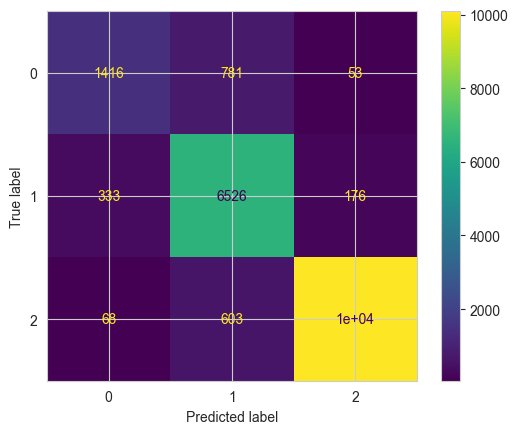

2025/04/14 02:46:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [331]:

with mlflow.start_run(run_name="RandomForest_Model", nested=True) as run:
    rf_params = pipeline_rf.get_params()
    
    pipeline_rf.fit(X_train, y_train)
    

    y_train_pred = pipeline_rf.predict(X_train)
    y_test_pred = pipeline_rf.predict(X_test)
    y_train_proba = pipeline_rf.predict_proba(X_train)

    scores_report = classification_report(y_test, y_test_pred, output_dict=True)
    print("Classification Report:\n", scores_report)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred)).plot()
    plt.show()
    # Evaluate
    rf_metrics = {
        'train_auc': multiclass_auc_scorer(pipeline_rf, X_train, y_train),
        'test_auc': multiclass_auc_scorer(pipeline_rf, X_test, y_test),
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'train_precision': scores_report["weighted avg"]["precision"],
        'test_precision': scores_report["weighted avg"]["precision"],
        'train_recall': scores_report["weighted avg"]["recall"],
        'test_recall': scores_report["weighted avg"]["recall"],
        'train_f1': scores_report["weighted avg"]["f1-score"],
        'test_f1': scores_report["weighted avg"]["f1-score"]
    }
    
    # Log to MLflow
    mlflow.sklearn.log_model(rf_model, "random_forest_model")
    log_model_details(rf_model, "RandomForest", features_used, rf_params, rf_metrics)

In [333]:
# Save preprocessing pipeline
joblib.dump(preprocess, "preprocess_pipeline.pkl")

['preprocess_pipeline.pkl']

In [334]:
# save model pipelineù
joblib.dump(pipeline_xgb, "pipeline_xgb.pkl")

['pipeline_xgb.pkl']

In [335]:
joblib.dump(pipeline_rf, "pipeline_rf.pkl")

['pipeline_rf.pkl']

In [336]:
# Save features list as JSON for reference
import json
with open("features_used.json", "w") as f:
    json.dump(features_used, f)
mlflow.log_artifact("features_used.json")

In [337]:
label_encoder.inverse_transform(xgb.classes_)

array(['<30', '>30', 'NO'], dtype=object)

In [339]:
print(classification_report(y_test, pipeline_rf.predict(X_test)))
print("Train AUC:", multiclass_auc_scorer(pipeline_rf, X_train, y_train))
print("Test AUC:", multiclass_auc_scorer(pipeline_rf, X_test, y_test))

              precision    recall  f1-score   support

           0       0.78      0.63      0.70      2250
           1       0.83      0.93      0.87      7035
           2       0.98      0.94      0.96     10764

    accuracy                           0.90     20049
   macro avg       0.86      0.83      0.84     20049
weighted avg       0.90      0.90      0.90     20049

Train AUC: 1.0
Test AUC: 0.9784407568441872


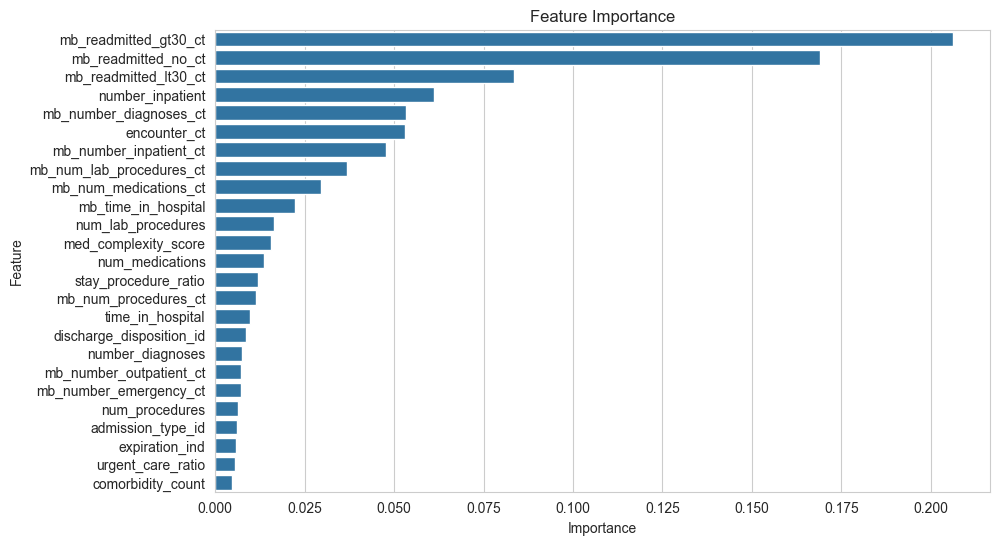

In [347]:
# Extract feature importances from the RandomForestClassifier
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1][:25]  # Top 10 features

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
sns.barplot(x=importances[indices], y=np.array(num_features)[indices], orient='h')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [348]:
df.to_csv("data/diabetic_cleaned_final.csv", index=False)